# Testing Transformer performance on CIFAR10 challenge according to different channel size
Trying to make the Encoder_MultiheadedAttention.py work for the CIFAR 10 challenge. 


In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import math

#from Encoder_MultiheadedAttention import Encoder

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.2098039].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.3352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.2411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].
Clipping input data to the valid 

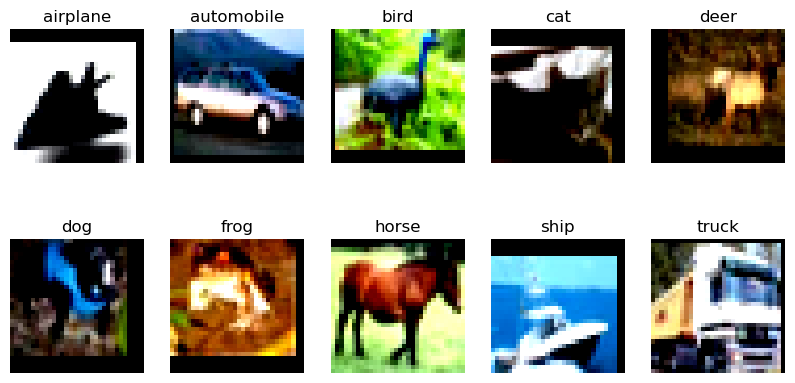

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
                                      ])
transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),])

batch_size = 128

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()

In [3]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            #print("Output: ", outputs[12])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #print("Total: ", total)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_init = validate(model, testloader, device)
    print(f"Accuracy before Training: {acc_init}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader): 
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            preds = model(inputs)
            
            
            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [ ]:
"""transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
    FlattenTransform()
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
    FlattenTransform()
])

# Update the datasets with the new transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Update the dataloaders with the new datasets
trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)"""

In [4]:
class Attention(nn.Module): 
    def __init__(self, dim_1, dim_2): 
        super(Attention, self).__init__()
        self.K = nn.Linear(dim_1, dim_2, bias=False)
        self.Q = nn.Linear(dim_1, dim_2, bias=False)
        self.V = nn.Linear(dim_1, dim_2, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x): 
        #print("X: ", x.size())
        scores = self.K(x) @ self.Q(x).transpose(-2, -1)
        #print("scores: ", scores.size())
        att_weight = self.softmax(scores / np.sqrt(x.shape[-1]))
        #print("att_weight", att_weight.size())
        out = att_weight @ self.V(x)
        #print("out weight: ", out.size())
        return out

class MultiHeadAttention(nn.Module): 
    def __init__(self, dim_1, dim_2, num_heads): 
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList(Attention(dim_1, dim_2) for _ in range(num_heads))
        self.Z = nn.Linear(num_heads * dim_1, dim_1)

    def forward(self, x): 
        #print(x.size())
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        #print(out.size())
        return self.Z(out)
    
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, max_len=32):
        super(PositionalEncoding2D, self).__init__()
        pe = torch.zeros(d_model, max_len, max_len)
        pos_x = torch.arange(max_len).unsqueeze(1)
        pos_y = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe[:, :, 0::2] = torch.sin(pos_x * div_term).unsqueeze(1)
        pe[:, :, 1::2] = torch.cos(pos_y * div_term).unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :x.size(2), :x.size(3)]
    
class EncoderLayer(nn.Module):
    def __init__(self, dim_1, head_size, num_heads, ff_size): 
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(dim_1, head_size, num_heads)
        self.layer_norm = nn.LayerNorm(dim_1)
        self.ff = nn.Sequential(
            nn.Linear(dim_1, ff_size), 
            nn.GELU(), 
            nn.Linear(ff_size, dim_1)
        )  
    
    def forward(self, x): 
        out = x + self.mha(x)
        out = self.layer_norm(out)
        temp = out
        out = temp + self.ff(out)
        out = self.layer_norm(out)
        return out

class Encoder(nn.Module): 
    def __init__(self, dim, head_size, num_heads, ff_size, num_encoders, num_classes): 
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(EncoderLayer(dim_1=dim, head_size=head_size, num_heads=num_heads, ff_size=ff_size) for _ in range(num_encoders))
        self.pe = PositionalEncoding2D(dim, max_len=32)
        self.linear = nn.Linear(dim, num_classes)
    
    def forward(self, x): 
        x = x + self.pe(x)
        for layer in self.layers: 
            x = layer(x)
        #print("X size: ", x.size())
        x = x.mean(dim=1) 
        x = x.mean(dim=1)
        out = self.linear(x)
        #print("Out size: ", out.size())
        return self.linear(x)


In [5]:
# Get one image from the dataset
image, label = trainset[0]

dim_1 = image.size(dim=1)
dim_2 = image.size(dim=2)
K = nn.Linear(dim_1, dim_2, bias=False)
Q = nn.Linear(dim_1, dim_2, bias=False)
V = nn.Linear(dim_1, dim_2, bias=False)
softmax = nn.Softmax(dim=-1)

scores = K(image) @ Q(image)
att_weight = softmax(scores / np.sqrt(image.shape[-1]))
out = att_weight @ V(image)


channel, x, y = out.size()
pos_x = torch.arange(x, device=out.device)
pos_y = torch.arange(y, device=out.device)
# Einfach erstmal zwei for schleifen die über alle channel alles iterieren? 

div_term_x = torch.exp(torch.arange(0, x, 2).float() * (-math.log(10000.0) / x))
div_term_y = torch.exp(torch.arange(0, y, 2).float() * (-math.log(10000.0) / y))

sin_inp_x = torch.sin(torch.einsum("i,j->ij", pos_x, div_term_x))
sin_inp_y = torch.cos(torch.einsum("i,j->ij", pos_y, div_term_y))

pe = torch.zeros(channel, x, y)

print(sin_inp_x.size())
print(sin_inp_y.size())

pe[:, :, 0::2 ] = torch.sin(sin_inp_x)
pe[:, :, 1::2] = torch.cos(sin_inp_y)



torch.Size([32, 16])
torch.Size([32, 16])


In [6]:
num_heads = 8  # Example number of heads
image, label = trainset[0]
dim_1 = image.size(dim=1)
dim_2 = image.size(dim=2)
# Initialize the Encoder model with the calculated dimensions
model = Encoder(dim=dim_1, head_size=dim_2, num_heads=num_heads, ff_size=1024, num_encoders=4, num_classes=10)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
train(model, trainloader, testloader, criterion, optimizer, num_epochs=40, device=device)

Accuracy before Training: 0.0907


100%|██████████| 215/215 [00:09<00:00, 23.68it/s]

Epoch 1, loss: 2.032440256517987


Accuracy on train set: 0.31923636363636365
Accuracy on test set: 0.1872


100%|██████████| 215/215 [00:09<00:00, 22.78it/s]

Epoch 2, loss: 1.8767824050992035


Accuracy on train set: 0.3614909090909091
Accuracy on test set: 0.2212


100%|██████████| 215/215 [00:08<00:00, 24.21it/s]

Epoch 3, loss: 1.8065768729808718


Accuracy on train set: 0.3805090909090909
Accuracy on test set: 0.2469


100%|██████████| 215/215 [00:08<00:00, 23.92it/s]

Epoch 4, loss: 1.752720658723698


Accuracy on train set: 0.39185454545454546
Accuracy on test set: 0.2555


100%|██████████| 215/215 [00:08<00:00, 25.14it/s]

Epoch 5, loss: 1.708345086075539


Accuracy on train set: 0.41392727272727275
Accuracy on test set: 0.2877


100%|██████████| 215/215 [00:09<00:00, 23.66it/s]

Epoch 6, loss: 1.6754323781922806


Accuracy on train set: 0.42916363636363636
Accuracy on test set: 0.2939


100%|██████████| 215/215 [00:09<00:00, 23.52it/s]

Epoch 7, loss: 1.6417185267736745


Accuracy on train set: 0.4358181818181818
Accuracy on test set: 0.2945


100%|██████████| 215/215 [00:09<00:00, 23.11it/s]

Epoch 8, loss: 1.618734569327776


Accuracy on train set: 0.4510181818181818
Accuracy on test set: 0.3043


100%|██████████| 215/215 [00:09<00:00, 22.65it/s]

Epoch 9, loss: 1.5939467757247214


Accuracy on train set: 0.4560727272727273
Accuracy on test set: 0.304


100%|██████████| 215/215 [00:09<00:00, 23.11it/s]

Epoch 10, loss: 1.577006948271463


Accuracy on train set: 0.46443636363636365
Accuracy on test set: 0.317


100%|██████████| 215/215 [00:08<00:00, 23.97it/s]

Epoch 11, loss: 1.5579153149626976


Accuracy on train set: 0.4658909090909091
Accuracy on test set: 0.3209


100%|██████████| 215/215 [00:09<00:00, 23.29it/s]

Epoch 12, loss: 1.5396816974462464


Accuracy on train set: 0.4792727272727273
Accuracy on test set: 0.3248


100%|██████████| 215/215 [00:09<00:00, 23.63it/s]

Epoch 13, loss: 1.526223387829093


Accuracy on train set: 0.4802181818181818
Accuracy on test set: 0.3278


100%|██████████| 215/215 [00:09<00:00, 23.68it/s]

Epoch 14, loss: 1.509558173667553


Accuracy on train set: 0.4892
Accuracy on test set: 0.3332


100%|██████████| 215/215 [00:09<00:00, 22.72it/s]

Epoch 15, loss: 1.4908257489980654


Accuracy on train set: 0.4905090909090909
Accuracy on test set: 0.3497


100%|██████████| 215/215 [00:09<00:00, 23.38it/s]

Epoch 16, loss: 1.4848638567813608


Accuracy on train set: 0.5009090909090909
Accuracy on test set: 0.3489


100%|██████████| 215/215 [00:09<00:00, 22.72it/s]

Epoch 17, loss: 1.471193077397901


Accuracy on train set: 0.5025090909090909
Accuracy on test set: 0.3477


100%|██████████| 215/215 [00:09<00:00, 21.96it/s]

Epoch 18, loss: 1.4585965711016988


Accuracy on train set: 0.5032363636363636
Accuracy on test set: 0.347


100%|██████████| 215/215 [00:09<00:00, 22.60it/s]

Epoch 19, loss: 1.4417730126270027


Accuracy on train set: 0.5120363636363636
Accuracy on test set: 0.3586


100%|██████████| 215/215 [00:08<00:00, 24.69it/s]

Epoch 20, loss: 1.430616687064947


Accuracy on train set: 0.5104363636363637
Accuracy on test set: 0.3587


100%|██████████| 215/215 [00:09<00:00, 23.71it/s]

Epoch 21, loss: 1.4241548360780227


Accuracy on train set: 0.5138909090909091
Accuracy on test set: 0.3642


100%|██████████| 215/215 [00:09<00:00, 23.56it/s]


Epoch 22, loss: 1.4127151394999304
Accuracy on train set: 0.5209818181818182
Accuracy on test set: 0.3634


100%|██████████| 215/215 [00:09<00:00, 23.03it/s]

Epoch 23, loss: 1.4005962538164716


Accuracy on train set: 0.5245090909090909
Accuracy on test set: 0.3699


100%|██████████| 215/215 [00:09<00:00, 23.05it/s]

Epoch 24, loss: 1.393120282749797


Accuracy on train set: 0.5327272727272727
Accuracy on test set: 0.3746


100%|██████████| 215/215 [00:09<00:00, 22.79it/s]

Epoch 25, loss: 1.3782876253128051


Accuracy on train set: 0.5342181818181818
Accuracy on test set: 0.3752


100%|██████████| 215/215 [00:09<00:00, 22.77it/s]

Epoch 26, loss: 1.373768006923587


Accuracy on train set: 0.5352
Accuracy on test set: 0.3802


100%|██████████| 215/215 [00:09<00:00, 23.63it/s]

Epoch 27, loss: 1.3659984300302905


Accuracy on train set: 0.5377090909090909
Accuracy on test set: 0.3758


100%|██████████| 215/215 [00:09<00:00, 23.25it/s]


Epoch 28, loss: 1.3558040313942488
Accuracy on train set: 0.5404727272727273
Accuracy on test set: 0.3791


100%|██████████| 215/215 [00:09<00:00, 23.19it/s]

Epoch 29, loss: 1.3461268541424773


Accuracy on train set: 0.5426181818181818
Accuracy on test set: 0.3851


100%|██████████| 215/215 [00:08<00:00, 25.65it/s]

Epoch 30, loss: 1.3441021242807079


Accuracy on train set: 0.5466181818181818
Accuracy on test set: 0.3854


100%|██████████| 215/215 [00:09<00:00, 22.83it/s]

Epoch 31, loss: 1.3257156399793404


Accuracy on train set: 0.5456727272727273
Accuracy on test set: 0.3836


100%|██████████| 215/215 [00:09<00:00, 22.92it/s]

Epoch 32, loss: 1.3212694334429365


Accuracy on train set: 0.5471636363636364
Accuracy on test set: 0.3925


100%|██████████| 215/215 [00:09<00:00, 22.77it/s]

Epoch 33, loss: 1.3170092172400896


Accuracy on train set: 0.5504363636363636
Accuracy on test set: 0.3935


100%|██████████| 215/215 [00:09<00:00, 23.56it/s]

Epoch 34, loss: 1.3111429680225462


Accuracy on train set: 0.554509090909091
Accuracy on test set: 0.3923


100%|██████████| 215/215 [00:09<00:00, 23.18it/s]

Epoch 35, loss: 1.298522969733837


Accuracy on train set: 0.55
Accuracy on test set: 0.4121


100%|██████████| 215/215 [00:09<00:00, 22.47it/s]

Epoch 36, loss: 1.2927673140237497


Accuracy on train set: 0.5578545454545455
Accuracy on test set: 0.3969


100%|██████████| 215/215 [00:08<00:00, 24.04it/s]

Epoch 37, loss: 1.2946674868117931


Accuracy on train set: 0.5582181818181818
Accuracy on test set: 0.4044


100%|██████████| 215/215 [00:09<00:00, 23.52it/s]

Epoch 38, loss: 1.285346988744514


Accuracy on train set: 0.5598909090909091
Accuracy on test set: 0.404


100%|██████████| 215/215 [00:09<00:00, 23.27it/s]

Epoch 39, loss: 1.2761744937231374


Accuracy on train set: 0.5617090909090909
Accuracy on test set: 0.3936


100%|██████████| 215/215 [00:09<00:00, 23.33it/s]

Epoch 40, loss: 1.2780568705048672


Accuracy on train set: 0.5643272727272727
Accuracy on test set: 0.4054
